### RFM-analysis

In [35]:
import pandas as pd
import numpy as np

# For visualization
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()

# Graphics in SVG format are more sharp and legible
get_ipython().run_line_magic('config', "InlineBackend.figure_format = 'svg'")

# Default plot size and set the color scheme
# plt.rcParams['figure.figsize'] = (6, 4)
# plt.rcParams['image.cmap'] = 'YlOrRd'

In [36]:
df = pd.read_csv('rfm_data.csv', sep=',', parse_dates=['InvoiceDate'], low_memory=False)
df

,InvoiceNo,CustomerCode,InvoiceDate,Amount
0,C0011810010001,19067290,2020-09-01,1716.00
1,C0011810010017,13233933,2020-09-01,1489.74
2,C0011810010020,99057968,2020-09-01,151.47
3,C0011810010021,80007276,2020-09-01,146.72
4,C0011810010024,13164076,2020-09-01,104.00
...,...,...,...,...
332725,S0081810310459,14092500,2020-09-30,3801.87
332726,S0081810310461,99065678,2020-09-30,5769.88
332727,S0081810310462,19029918,2020-09-30,736.88
332728,S0081810310463,13020033,2020-09-30,1475.20


In [37]:
df.dtypes

InvoiceNo               object
CustomerCode            object
InvoiceDate     datetime64[ns]
Amount                 float64
dtype: object

In [5]:
# check the period
df['InvoiceDate'].describe(datetime_is_numeric=True)

count                           332730
mean     2020-09-15 16:35:03.846361856
min                2020-09-01 00:00:00
25%                2020-09-08 00:00:00
50%                2020-09-16 00:00:00
75%                2020-09-24 00:00:00
max                2020-09-30 00:00:00
Name: InvoiceDate, dtype: object

In [38]:
df.CustomerCode.nunique()

123733

Group by customer and calculate RFM scores:<br>
- Recency (Number of days since the last purchase)<br>
- Frequency (Number of orders for the whole period in data)<br>
- Monetary Value (Total sales)

In [39]:
# The date of the last purchase:
last_date = df['InvoiceDate'].max()
last_date

Timestamp('2020-09-30 00:00:00')

In [40]:
RFM_Table = df.groupby('CustomerCode').agg({'InvoiceDate': lambda x: (last_date - x.max()).days,
                                        'InvoiceNo': lambda x: len(x),
                                        'Amount': lambda x: x.sum()})

RFM_Table['InvoiceDate'] = RFM_Table['InvoiceDate'].astype(int)
RFM_Table.rename(columns={'InvoiceDate': 'Recency', 
                         'InvoiceNo': 'Frequency', 
                         'Amount': 'Monetary_Value'}, inplace=True)

In [41]:
RFM_Table

,Recency,Frequency,Monetary_Value
CustomerCode,,,
02213019,19,1,1609.20
02213042,22,3,9685.48
02213071,29,1,415.00
02213088,23,1,305.00
02213092,25,1,1412.88
...,...,...,...
99099927,10,1,961.10
99099936,0,1,1521.78
99099959,8,2,1444.56


In [43]:
# Check if the number of customers is equal to the number of unique customers in df
RFM_Table.shape[0] == df.CustomerCode.nunique()

True

In [44]:
RFM_Table.Frequency.max()

204

There will be 4 categories for each RFM attribute.<br> Using quantiles set the score limits for categories: 

In [45]:
quantiles = RFM_Table.quantile(q=[0.25, 0.5, 0.75])
quantiles

,Recency,Frequency,Monetary_Value
0.25,2.0,1.0,765.00
0.50,8.0,2.0,1834.48
0.75,16.0,3.0,4008.84


Create functions for assigning categories. Require a value, a parameter name and a table as a reference.<br>
The first-category customer has purchased recently, purchases frequently and generally spends more. 

In [46]:

def RClass(value, parameter_name, quantiles_table):
    if value <= quantiles_table[parameter_name][0.25]:
        return 1
    elif value <= quantiles_table[parameter_name][0.50]:
        return 2
    elif value <= quantiles_table[parameter_name][0.75]: 
        return 3
    else:
        return 4


def FMClass(value, parameter_name,quantiles_table):
    if value <= quantiles_table[parameter_name][0.25]:
        return 4
    elif value <= quantiles_table[parameter_name][0.50]:
        return 3
    elif value <= quantiles_table[parameter_name][0.75]: 
        return 2
    else:
        return 1


In [47]:
RFM_Segmentation = RFM_Table

In [48]:
RFM_Segmentation['R_Quartile'] = RFM_Segmentation['Recency'].apply(RClass, args=('Recency', quantiles))

RFM_Segmentation['F_Quartile'] = RFM_Segmentation['Frequency'].apply(FMClass, args=('Frequency', quantiles))

RFM_Segmentation['M_Quartile'] = RFM_Segmentation['Monetary_Value'].apply(FMClass, args=('Monetary_Value', quantiles))

RFM_Segmentation['RFM_Class'] = RFM_Segmentation.R_Quartile.map(str) + RFM_Segmentation.F_Quartile.map(str) + RFM_Segmentation.M_Quartile.map(str)

In [49]:
RFM_Segmentation

,Recency,Frequency,Monetary_Value,R_Quartile,F_Quartile,M_Quartile,RFM_Class
CustomerCode,,,,,,,
02213019,19,1,1609.20,4,4,3,443
02213042,22,3,9685.48,4,2,1,421
02213071,29,1,415.00,4,4,4,444
02213088,23,1,305.00,4,4,4,444
02213092,25,1,1412.88,4,4,3,443
...,...,...,...,...,...,...,...
99099927,10,1,961.10,3,4,3,343
99099936,0,1,1521.78,1,4,3,143
99099959,8,2,1444.56,2,3,3,233


In [51]:
pd.crosstab(index = RFM_Segmentation.R_Quartile, columns = RFM_Segmentation.F_Quartile)

F_Quartile,1,2,3,4
R_Quartile,,,,
1,14433,4671,5795,6074
2,9634,5889,8633,10399
3,3091,3748,7734,13263
4,542,1311,5415,23101


In [52]:
RFM_table = RFM_Segmentation.pivot_table(
                        index='R_Quartile', 
                        columns='F_Quartile', 
                        values='Monetary_Value', 
                        aggfunc=np.median).applymap(int)

The heatmap shows medians of total value of all purchases by customer for each category:

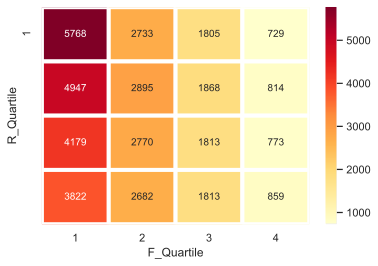

In [53]:
# # Plot size
plt.rcParams['figure.figsize'] = (6, 4)

plt.gca()

# Heat Map chart
sns.heatmap(RFM_table, cmap="YlOrRd", annot=True, fmt=".0f", linewidths=4, annot_kws={"size": 10}, yticklabels=4)
pass

In [54]:
# Number of users by Class
RFM_Segmentation['RFM_Class'].value_counts().sort_values()

414        2
314       33
214       60
114       60
424       63
       ...  
211     5847
344     6593
443     6729
111     9705
444    10624
Name: RFM_Class, Length: 64, dtype: int64